# WCWH Community Rollout Preparation - BEVO Beacon Design
For the upcoming rollout, we need to ensure proper aspects of the beacon are working correctly.

In [8]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Internal Temperature
The purpose of this notebook is to analyze the data from a few beacons to see how the temperature readings change depending on various design considerations.

In [9]:
import os
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

from src.diagnostics import thermal_analysis

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm

## Design Considerations
The design considerations are as follows and analyzed separately:
1. **As-Is**: The do-nothing approach that might be fine based on the temperatures since not much analysis has been done with the temperature up to this point
2. **Double Fans**: Adding an extra fan might increase the air flow and reduce the amount of hot air trapped in the beacon
3. **Heat Sinks**: Adding heat sinks on the processor might be enough to dissipate the heat effectively
4. **Fans and Heat Sinks**: Of course the final, and most comprehensive idea would be to combine ideas 2 and 3.

In [16]:
t_check = thermal_analysis.Internal_Temperature_Check(beacons=[5,6,25,29,30,44],
                                                    start_time=datetime(2021,10,19,15,5,0),end_time=datetime(2021,10,19,17,40,0))
t_check.set_data()
t_check.data.fillna(-1)

,timestamp,co,co2,no2,pm1_mass,pm10_mass,pm2p5_mass,pm1_number,pm10_number,pm2p5_number,temperature_c_internal,tvoc,beacon,temperature_c,lux,rh
0,2021-10-19 15:09:00,-0.390029,-1.000000,-0.793346,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,5,18.327147,-1.000,51.0
1,2021-10-19 15:10:00,-0.691634,-1.000000,-0.828088,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,5,18.327147,-1.000,51.0
2,2021-10-19 15:11:00,-0.993240,-1.000000,-0.923628,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,5,18.327147,-1.000,51.0
3,2021-10-19 15:12:00,-0.890525,-1.000000,-0.984426,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,5,18.327147,-1.000,51.0
4,2021-10-19 15:13:00,-0.794077,-1.000000,-0.984426,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,5,18.327147,-1.000,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2021-10-19 17:35:00,-1.000000,612.375156,4362.600000,-0.328586,0.818772,-6.325055,-5.143508,6.575634,-6.362892,23.640135,358.563525,44,19.370938,56.712,54.0
746,2021-10-19 17:36:00,-1.000000,622.775872,4619.200000,-0.237056,1.370075,1.632209,-4.852163,9.457747,-4.920980,23.505283,367.269229,44,19.370938,58.752,54.0
747,2021-10-19 17:37:00,-1.000000,633.144281,4707.600000,-0.329067,0.864548,-5.712642,-5.277512,6.590273,-6.378186,23.467232,372.082971,44,19.370938,58.752,54.0
748,2021-10-19 17:38:00,-1.000000,792.370128,4801.400000,-0.277780,1.146133,-1.621256,-5.039896,8.188474,-5.565914,23.747616,375.770093,44,19.370938,58.752,54.0


In [17]:
t_check.data.set_index("timestamp").to_csv("/Users/hagenfritz/Desktop/temp_check_data/combined.csv")

### Analysis Class
The class below provides the framework to do the majority of the analysis.

In [51]:
class Internal_Temperature_Analysis:
    
    def __init__(self,beacon_list,ref_beacon,exp_start_datetime=datetime(2021,1,1,0,0),exp_end_datetime=datetime(2022,1,1,0,0),var="temperature_c"):
        # getting beacon data
        self.test_beacons = beacon_list
        self.ref_beacons = ref_beacon
        self.all_beacons = beacon_list + ref_beacon
        beacon = pd.read_csv("../data/processed/beacon-wcwh_0.csv",index_col=0,parse_dates=True,infer_datetime_format=True)
        self.data = beacon[beacon["beacon"].isin(beacon_list)] # experiment data
        self.ref = beacon[beacon["beacon"].isin(ref_beacon)] # reference beacon
        self.ref = self.ref.groupby(self.ref.index).mean() # averaging the ref beacon(s) data
        
        # other important paramters
        self.starting = exp_start_datetime
        self.ending = exp_end_datetime
        self.var = var
    
    def compare_timeseries(self):
        """
        Compares the time series measurements of the list of beacons
        """
        fig, ax = plt.subplots(figsize=(12,6))
        for bb in self.test_beacons:
            data_by_bb = self.data[self.data["beacon"] == bb]
            ax.plot(data_by_bb.index,data_by_bb[self.var],linewidth=2,label=bb,zorder=bb) # test lines
        
        ax.plot(self.ref.index,self.ref[self.var],linewidth=3,color="black",label="Reference",zorder=0) # reference line
            
        ax.set_xlim([self.starting,self.ending])
        ax.set_ylim([20,30])
        ax.legend()
        plt.show()
        plt.close()
        
    def compare_stats(self):
        """
        Compares some common summary statistics between the beacons used in the test
        """
        stat_dict = {"beacon":[],"mean":[],"median":[],"std":[]}
        for bb in self.test_beacons:
            data_by_bb = self.data[self.data["beacon"] == bb]
            stat_dict["beacon"].append(bb)
            stat_dict["mean"].append(np.nanmean(data_by_bb[self.var]))
            stat_dict["median"].append(np.nanmedian(data_by_bb[self.var]))
            stat_dict["std"].append(np.nanstd(data_by_bb[self.var]))
            
        stat_dict["beacon"].append("reference")
        stat_dict["mean"].append(np.nanmean(self.ref[self.var]))
        stat_dict["median"].append(np.nanmedian(self.ref[self.var]))
        stat_dict["std"].append(np.nanstd(self.ref[self.var]))
            
        return pd.DataFrame(data=stat_dict).set_index("beacon")
        
    def get_delta(self):
        """
        Gets the mean and median temperature differences
        """
        delta_dict = {"beacon":[],"mean":[],"median":[]}
        for bb in self.test_beacons:
            data_by_bb = self.data[self.data["beacon"] == bb]
            avg = np.nanmean(data_by_bb[self.var]) - np.nanmean(self.ref[self.var])
            med = np.nanmedian(data_by_bb[self.var]) - np.nanmedian(self.ref[self.var])
            for key, val in zip(delta_dict.keys(),[bb,avg,med]):
                delta_dict[key] = val
                
        return delta_dict

### As-Is
Here is the analysis from the first analysis.

In [43]:
exp1 = Internal_Temperature_Analysis(beacon_list=[7,24])
exp1.compare_timeseries()

TypeError: __init__() missing 1 required positional argument: 'ref_beacon'

### Double Fans
Adding an extra fan should provide more ventilation and therefore cooler temperatures inside the RPi. 

In [52]:
exp2 = Internal_Temperature_Analysis([7],[20],datetime(2021,1,23,0,0),datetime(2021,1,25,16,0))

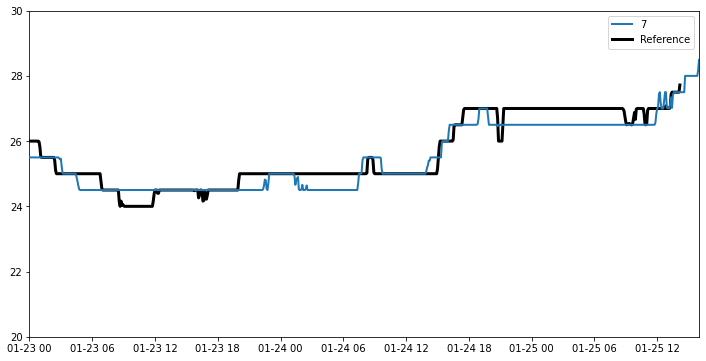

In [53]:
exp2.compare_timeseries()

In [54]:
df = exp2.compare_stats()
df.head()

,mean,median,std
beacon,,,
7,23.627978,23.99,2.055233
reference,25.093238,25.00,1.090262
